In [30]:
from apportionment import *

# for i in range(10):
#     raw2visualisable(f"1m-2023multiTEST{i}.csv", weighted=False)

# for i in range(10):
#     print(f'starting {i}')
#     raw2visualisable(f"1m-2023multiTEST{i}.csv", weighted=False, multi=True)
#     print(f'finished {i}')


In [31]:
# csv_files = [f"./vis_data/unweighted-vis-1m-2023multiTEST{i}.csv" for i in range(10)]

# combined_df = pd.concat([pd.read_csv(f) for f in csv_files])

# averaged_df = combined_df.groupby(["samples", "proportion"]).mean().reset_index()

# averaged_df.to_csv("./vis_data/vis-1m-2023multiTOTALsep.csv", index=False)

# print("Compression complete")

In [32]:
# year = 2023

# with sqlite3.connect('multi.db') as conn:
#     cur = conn.cursor()

#     cur.execute(f'''
#         SELECT iteration_number, party_number, MIN(samples) 
#         FROM tab{year} 
#         WHERE diff > 0 
#         GROUP BY iteration_number, party_number, party_number2, proportion;
#     ''')

#     results = cur.fetchall()

#     with open(f'lowest_samples{year}MULTIall.csv', 'w', newline='') as csvfile:
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow(['iteration_number', 'party_number', 'party_number2', 'lowest_samples', 'proportion'])
#         csvwriter.writerows(results)

#     exclude_list = ", ".join(map(str, constants.le_exclude[year]))

#     cur.execute(f'''
#         SELECT iteration_number, party_number, MIN(samples) 
#         FROM tab{year} 
#         WHERE diff > 0 AND party_number IN ({exclude_list}) 
#         GROUP BY iteration_number, party_number, party_number2, proportion;
#     ''')

#     results = cur.fetchall()

#     with open(f'lowest_samples{year}MULTInon_el.csv', 'w', newline='') as csvfile:
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow(['iteration_number', 'party_number', 'party_number2', 'lowest_samples', 'proportion'])
#         csvwriter.writerows(results)

#     cur.execute(f'''
#         SELECT iteration_number, party_number, MIN(samples) 
#         FROM tab{year} 
#         WHERE diff > 0 AND party_number NOT IN ({exclude_list}) 
#         GROUP BY iteration_number, party_number, party_number2, proportion;
#     ''')

#     results = cur.fetchall()

#     with open(f'lowest_samples{year}MULTIelectable.csv', 'w', newline='') as csvfile:
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow(['iteration_number', 'party_number', 'party_number2', 'lowest_samples', 'proportion'])
#         csvwriter.writerows(results)

In [33]:
db_file = 'multi.db'

if not os.path.exists(db_file):
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
            
    cur.execute(f'''CREATE TABLE IF NOT EXISTS tab2023 (
                iteration_number INTEGER,
                party_number INTEGER,
                party_number2 INTEGER,
                samples INTEGER,
                diff INTEGER,
                proportion INTEGER
                );''')

    for i in range(10):
        with open(f'./raw_data/1m-2023multiTEST{i}.csv', 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header if exists
            for i, row in enumerate(reader):
                cur.execute(f'''INSERT INTO tab2023 (iteration_number, party_number, party_number2, samples, diff, proportion)
                                VALUES (?, ?, ?, ?, ?, ?);''', row)
    conn.commit()
    conn.close()

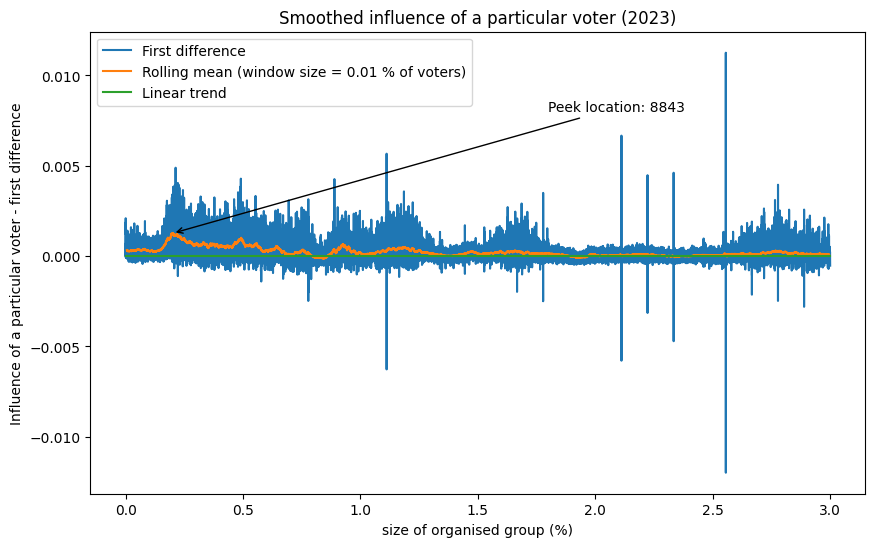

In [34]:
df100 = pd.read_csv("./vis_data/vis-1m-2023.csv")
df = pd.read_csv("./vis_data/vis-1m-2023multiTOTAL.csv")

df.iloc[:, -1] = (1 * df100.iloc[:, -1] + 5 * df.iloc[:, -1]) / 6

x_values = (df['samples'] / 1000000) * 100
y_values = df['diff']
y_vals =  y_values - (3 * x_values)

y_deriv = y_vals.diff()
y_rolling = y_deriv.rolling(window=100, center=True).mean()

x = np.arange(0, 4)
y = 3 * x

plt.figure(figsize=(10, 6))

plt.plot(x_values, y_deriv, '-', markersize=1, label="First difference")
plt.plot(x_values, y_rolling, '-', markersize=1, label="Rolling mean (window size = 0.01 % of voters)")
plt.plot(x, y * 0, label='Linear trend')

plt.xlabel('size of organised group (%)')
plt.ylabel('Influence of a particular voter - first difference')
plt.title('Smoothed influence of a particular voter (2023)')

plt.legend()

max_index = y_rolling.idxmax()
plt.annotate(f'Peek location: {int(max_index * (4388872 / 1000000))}', xy=(x_values[max_index], y_rolling[max_index]),
                xytext=(1.8, 0.008),
                arrowprops=dict(facecolor='black', arrowstyle='->'))


plt.show()

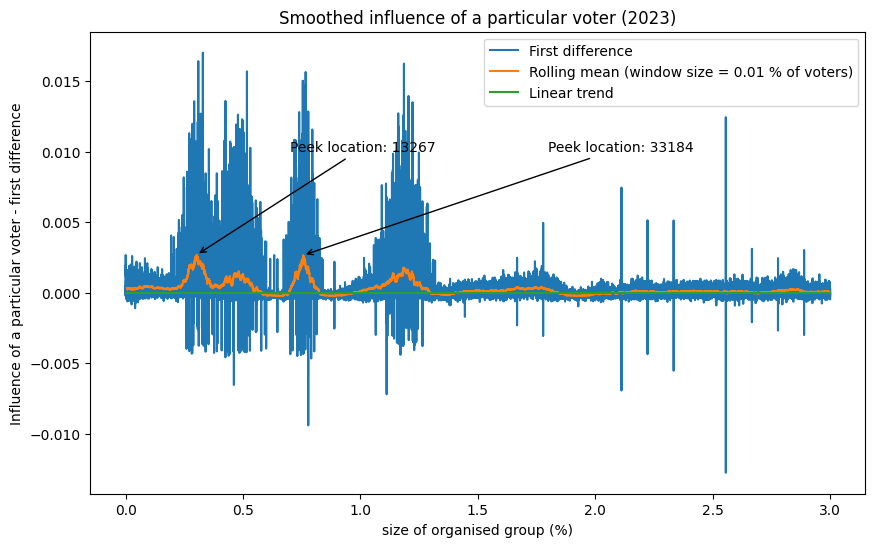

In [43]:
df = pd.read_csv("./vis_data/vis-1m-2023multiTOTALsep.csv")
df100['proportion'] = 100

df = pd.concat([df, df100])
df = df.sort_values(by=['samples', 'proportion'])
df = df.reset_index(drop=True)

dfprop = df[df['proportion'] == 60]
dfprop = dfprop.reset_index(drop=True)

x_values = (dfprop['samples'] / 1000000) * 100
y_values = dfprop['diff']
y_vals =  y_values - (3 * x_values)

y_deriv = y_vals.diff()
y_rolling = y_deriv.rolling(window=100, center=True).mean()

x = np.arange(0, 4)
y = 3 * x

plt.figure(figsize=(10, 6))

plt.plot(x_values, y_deriv, '-', markersize=1, label="First difference")
plt.plot(x_values, y_rolling, '-', markersize=1, label="Rolling mean (window size = 0.01 % of voters)")
plt.plot(x, y * 0, label='Linear trend')

plt.xlabel('size of organised group (%)')
plt.ylabel('Influence of a particular voter - first difference')
plt.title('Smoothed influence of a particular voter (2023)')

plt.legend()

max_index = y_rolling[:4000].idxmax()
plt.annotate(f'Peek location: {int(max_index * (4388872 / 1000000))}', xy=(x_values[max_index], y_rolling[max_index]),  
                xytext=(0.7, 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

max_index = y_rolling[4000:].idxmax()
plt.annotate(f'Peek location: {int(max_index * (4388872 / 1000000))}', xy=(x_values[max_index], y_rolling[max_index]),
                xytext=(1.8, 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

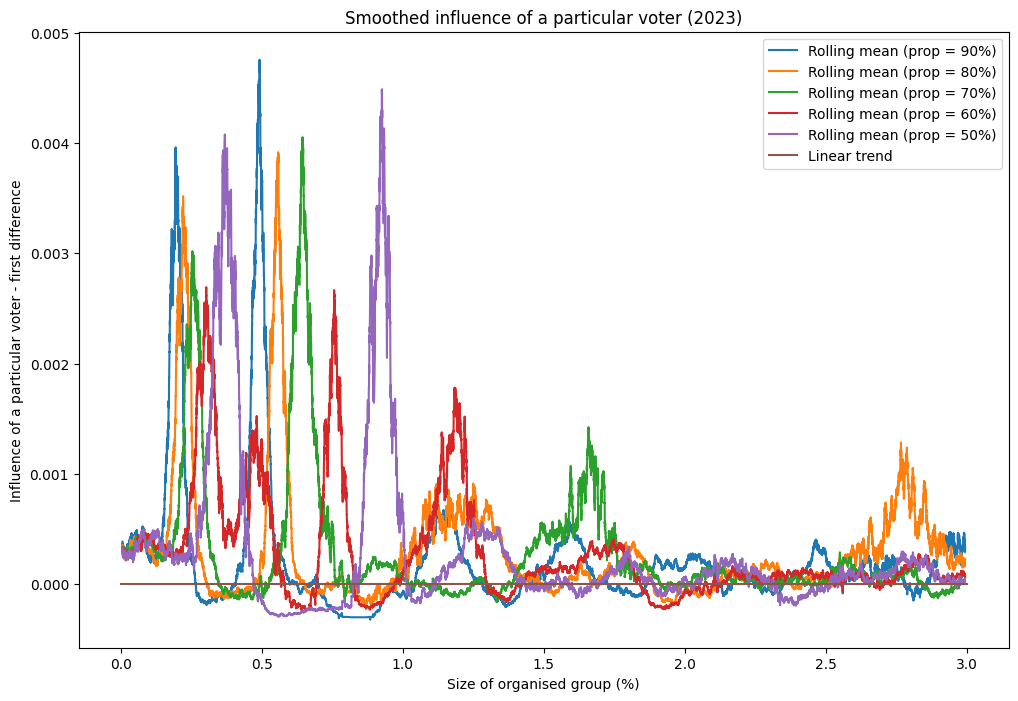

,samples,proportion,diff
0,1,50,0.003571
1,1,60,0.003439
2,1,70,0.003263
3,1,80,0.003527
4,1,90,0.003483
...,...,...,...
149995,30000,50,17.365697
149996,30000,60,17.439749
149997,30000,70,17.371671
149998,30000,80,17.918408


                 mean       std
proportion                     
50          10.636384  4.923234
60          10.602867  4.918894
70          10.421992  4.958814
80           9.860270  4.668192
90           9.110296  3.999568


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("./vis_data/vis-1m-2023multiTOTALsep.csv")

# Sort and reset index
df = df.sort_values(by=['samples', 'proportion'])
df = df.reset_index(drop=True)

# List of proportions to plot
proportions = [90, 80, 70, 60, 50]

# Create a figure
plt.figure(figsize=(12, 8))

# Generate plots for each proportion
for prop in proportions:
    # Filter data for the current proportion
    dfprop = df[df['proportion'] == prop]
    dfprop = dfprop.reset_index(drop=True)

    # Calculate x and y values
    x_values = (dfprop['samples'] / 1000000) * 100
    y_values = dfprop['diff']
    y_vals = y_values - (3 * x_values)

    # Calculate the rolling mean of the first difference
    y_deriv = y_vals.diff()
    y_rolling = y_deriv.rolling(window=100, center=True).mean()

    # Plot the rolling mean
    plt.plot(x_values, y_rolling, '-', markersize=1, label=f"Rolling mean (prop = {prop}%)")

# Define the linear trend line
x = np.arange(0, 4)
y = 3 * x

# Plot the linear trend line
plt.plot(x, y * 0, label='Linear trend')

# Add labels and title
plt.xlabel('Size of organised group (%)')
plt.ylabel('Influence of a particular voter - first difference')
plt.title('Smoothed influence of a particular voter (2023)')

# Add legend
plt.legend()

# Show the plot
plt.show()

display(df
)
# Calculate mean and standard deviation for each proportion
mean_std_df = df.groupby('proportion')['diff'].agg(['mean', 'std'])

# Print the results
print(mean_std_df)